## Project Title: Gender Bias and Academic Influence on Job Placement Outcomes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from simple_colors import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw=pd.read_csv('Job_Placement_Data.csv')

In [3]:
df=raw.copy()
df

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed
2,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed
3,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed
4,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,M,80.60,Others,82.00,Others,Commerce,77.60,Comm&Mgmt,No,91.0,Mkt&Fin,74.49,Placed
211,M,58.00,Others,60.00,Others,Science,72.00,Sci&Tech,No,74.0,Mkt&Fin,53.62,Placed
212,M,67.00,Others,67.00,Others,Commerce,73.00,Comm&Mgmt,Yes,59.0,Mkt&Fin,69.72,Placed
213,F,74.00,Others,66.00,Others,Commerce,58.00,Comm&Mgmt,No,70.0,Mkt&HR,60.23,Placed


#### Column info

| Column Name         | Full Name / Meaning                                                                 |
| --------------------| ----------------------------------------------------------------------------------- |
| gender              | Gender of the student (Male or Female)                                              |
| ssc_percentage      | Secondary School Certificate (10th grade) marks percentage                          |
| ssc_board           | Education board of the student for 10th grade (e.g., Central, Others)               |
| hsc_percentage      | Higher Secondary Certificate (12th grade) marks percentage                          |
| hsc_board           | Education board of the student for 12th grade (e.g., Central, Others)               |
| hsc_subject         | Stream chosen in 12th grade (e.g., Science, Commerce, Arts)                         |
| degree_percentage   | Percentage scored in undergraduate degree                                           |
| undergrad_degree    | Field of study in undergraduate degree (e.g., Science & Technology, Commerce, Arts) |
| work_experience     | Whether the student has prior work experience (Yes/No)                              |
| emp_test_percentage | Score obtained in the employability test conducted by the institute                 |
| specialisation      | MBA specialization (e.g., Marketing & HR, Marketing & Finance)                      |
| mba_percent         | Percentage scored in MBA                                                            |
| status              | Placement status (Placed or Not Placed)                                             |


                                                      Basic Checks

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               215 non-null    object 
 1   ssc_percentage       215 non-null    float64
 2   ssc_board            215 non-null    object 
 3   hsc_percentage       215 non-null    float64
 4   hsc_board            215 non-null    object 
 5   hsc_subject          215 non-null    object 
 6   degree_percentage    215 non-null    float64
 7   undergrad_degree     215 non-null    object 
 8   work_experience      215 non-null    object 
 9   emp_test_percentage  215 non-null    float64
 10  specialisation       215 non-null    object 
 11  mba_percent          215 non-null    float64
 12  status               215 non-null    object 
dtypes: float64(5), object(8)
memory usage: 22.0+ KB


### Data Validation and Understanding

Before performing any analysis, it's important to validate the dataset to ensure its accuracy, completeness, and reliability. In this step, I examine each column for missing values, inconsistent entries, incorrect data types, and outliers. This helps establish trust in the data and guides how I will clean or transform it.

In [5]:
# Missing Values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

print(green("============= Dataset Structure Analysis ============",['bold']))
print()
print("Total rows: ",len(df))
print("Total columns: ",len(df.columns))

print()
print(green("============= Missing Values Analysis ============",['bold']))
print()
missing_info = pd.DataFrame(
    {
    "Missing Values": missing_values,
    "Percentage": missing_percentage
     }).query('`Missing Values` > 0')

if not missing_info.empty:
    display(missing_info)
else:
    print('No missing values found in the dataset!')


# Check categorical distributions
categorical_cols = df.select_dtypes(include='object').columns
print()
print(green("============= Categorical Columns Distribution ============",['bold']))
for col in categorical_cols:
    print(magenta(f'\n{col} value counts:',['bold']))
    print(df[col].value_counts())
    print()

# Check if any object-type column can be converted to numeric
print()
print(green("============= Object Columns That Might Be Numeric ============",['bold']))
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            pd.to_numeric(df[col], errors='raise')
            print(f"Column '{col}' can be converted to numeric.")
        except:
            continue

# Summary of Categorical Variables
def summarize_categorical(df):
    print()
    print(green("============= Categorical Summary ============",['bold']))
    print()
    for col in categorical_cols:
        print(magenta(f'\n{col}:',['bold']))
        value_counts = df[col].value_counts()
        percentage = df[col].value_counts(normalize=True) * 100
        summary = pd.DataFrame({'Count': value_counts, 'Percentage (%)': percentage.round(2)})
        display(summary)

summarize_categorical(df)

============= Dataset Structure Analysis ============

Total rows:  215
Total columns:  13

============= Missing Values Analysis ============

No missing values found in the dataset!

============= Categorical Columns Distribution ============

gender value counts:
M    139
F     76
Name: gender, dtype: int64


ssc_board value counts:
Central    116
Others      99
Name: ssc_board, dtype: int64


hsc_board value counts:
Others     131
Central     84
Name: hsc_board, dtype: int64


hsc_subject value counts:
Commerce    113
Science      91
Arts         11
Name: hsc_subject, dtype: int64


undergrad_degree value counts:
Comm&Mgmt    145
Sci&Tech      59
Others        11
Name: undergrad_degree, dtype: int64


work_experience value counts:
No     141
Yes     74
Name: work_experience, dtype: int64


specialisation value counts:
Mkt&Fin    120
Mkt&HR      95
Name: specialisation, dtype: int64


status value counts:
Placed        148
Not Placed     67
Name: status, dtype: int64


=============

,Count,Percentage (%)
M,139,64.65
F,76,35.35



ssc_board:


,Count,Percentage (%)
Central,116,53.95
Others,99,46.05



hsc_board:


,Count,Percentage (%)
Others,131,60.93
Central,84,39.07



hsc_subject:


,Count,Percentage (%)
Commerce,113,52.56
Science,91,42.33
Arts,11,5.12



undergrad_degree:


,Count,Percentage (%)
Comm&Mgmt,145,67.44
Sci&Tech,59,27.44
Others,11,5.12



work_experience:


,Count,Percentage (%)
No,141,65.58
Yes,74,34.42



specialisation:


,Count,Percentage (%)
Mkt&Fin,120,55.81
Mkt&HR,95,44.19



status:


,Count,Percentage (%)
Placed,148,68.84
Not Placed,67,31.16


### Manual Column-wise Data Validation

As part of the data validation process, I manually reviewed each column in the dataset to understand the unique values, spot potential anomalies, and ensure consistency in categorical entries. This step helps identify data quality issues like inconsistent spelling, case sensitivity, and unexpected values.

In [6]:
def colValidate(df,col):
    print(f"column : {col}")
    print()
    print(f"Number of unique values in column: {df[col].nunique()}")
    print()
    print("Unique Values:")
    if df[col].nunique() >=100:
        for i in range(0,df[col].nunique(),100):
            print(df[col].unique()[i:i+100])
            print()
    else:
        print(df[col].unique())
        print()
    print(f"Data type of column:{df[col].dtype}")
    print()

#### Gender

In [7]:
colValidate(df,'gender')

column : gender

Number of unique values in column: 2

Unique Values:
['M' 'F']

Data type of column:object



#### ssc_percentage

In [8]:
colValidate(df,'ssc_percentage')

column : ssc_percentage

Number of unique values in column: 103

Unique Values:
[67.   79.33 65.   56.   85.8  55.   46.   82.   73.   58.   69.6  47.
 77.   62.   63.   60.   79.   69.8  77.4  76.5  52.58 71.   76.76 64.
 61.   87.   69.   51.   81.   78.   74.   49.   76.   70.89 50.   75.2
 54.4  40.89 80.   60.4  68.   52.6  84.2  86.5  54.   83.   80.92 69.7
 75.   84.86 64.6  56.6  59.   66.5  84.   81.7  70.   83.84 59.6  66.
 85.   52.   60.23 70.5  45.   61.08 69.5  73.96 68.2  60.8  72.   80.4
 76.7  74.9  77.44 77.67 89.4  44.   75.4  53.   51.57 55.6  74.2  67.16
 63.3  67.9  48.   59.96 63.4  73.24 77.8  56.28 88.   78.5  61.8  65.2
 83.96 54.2  55.68 41.  ]

[83.33 43.   80.6 ]

Data type of column:float64



#### SSC Board

In [9]:
colValidate(df,'ssc_board')

column : ssc_board

Number of unique values in column: 2

Unique Values:
['Others' 'Central']

Data type of column:object



#### HSC percentage

In [10]:
colValidate(df,'hsc_percentage')

column : hsc_percentage

Number of unique values in column: 97

Unique Values:
[91.   78.33 68.   52.   73.6  49.8  49.2  64.   79.   70.   61.   68.4
 55.   87.   47.   75.   66.2  67.   66.   65.   76.   60.8  60.   97.7
 54.6  76.5  73.5  53.   81.   51.   78.   44.   58.   77.   63.16 39.
 73.   71.98 62.   37.   73.2  61.12 45.83 66.6  71.4  65.58 73.4  64.2
 74.   78.5  70.29 83.83 64.8  70.4  80.   90.9  63.   89.83 90.   57.
 69.   62.5  82.   72.   50.   54.   72.8  40.   66.8  59.   71.   89.7
 92.   56.   64.89 65.66 86.   58.66 60.5  74.66 69.4  49.   87.6  72.5
 42.16 67.2  50.83 97.   71.5  60.33 62.83 65.5  77.6  70.2  61.4  61.33
 42.  ]

Data type of column:float64



#### HSC Board

In [11]:
colValidate(df,'hsc_board')

column : hsc_board

Number of unique values in column: 2

Unique Values:
['Others' 'Central']

Data type of column:object



#### HSC Subjects

In [12]:
colValidate(df,'hsc_subject')

column : hsc_subject

Number of unique values in column: 3

Unique Values:
['Commerce' 'Science' 'Arts']

Data type of column:object



#### Degree Percentage

In [13]:
colValidate(df,'degree_percentage')

column : degree_percentage

Number of unique values in column: 89

Unique Values:
[58.   77.48 64.   52.   73.3  67.25 79.   66.   72.   61.   60.   78.3
 65.   59.   50.   69.   65.6  70.   85.   72.23 64.74 78.86 50.2  67.5
 73.   66.4  81.   57.   80.   68.   68.4  56.2  53.   61.4  74.   72.11
 66.89 67.4  75.   67.   72.7  62.   71.   78.   71.72 70.2  77.5  71.93
 64.5  77.2  82.   50.8  54.   76.   63.   83.   66.6  64.6  69.6  69.3
 64.33 75.5  77.72 77.   69.5  73.43 70.67 71.25 56.   55.   84.   59.9
 60.9  57.5  77.25 63.35 61.26 64.27 64.2  62.8  64.21 59.79 54.38 69.2
 64.8  56.3  91.   56.87 77.6 ]

Data type of column:float64



#### Undergraduate Degree

In [14]:
colValidate(df,'undergrad_degree')

column : undergrad_degree

Number of unique values in column: 3

Unique Values:
['Sci&Tech' 'Comm&Mgmt' 'Others']

Data type of column:object



#### Work Experience

In [15]:
colValidate(df,'work_experience')

column : work_experience

Number of unique values in column: 2

Unique Values:
['No' 'Yes']

Data type of column:object



#### Employee test percentage

In [16]:
colValidate(df,'emp_test_percentage')

column : emp_test_percentage

Number of unique values in column: 100

Unique Values:
[55.   86.5  75.   66.   96.8  74.28 67.   91.34 54.   62.   60.   68.
 76.   72.   50.48 50.   95.   55.53 92.   97.4  94.   73.35 77.   52.
 64.   50.89 88.   68.44 71.   58.   53.7  93.   65.   63.   89.   78.
 71.2  87.   80.   74.   57.6  61.6  59.   68.5  61.   89.69 68.92 68.71
 79.   70.   95.5  86.   84.27 69.   86.04 82.   84.   78.74 53.88 95.46
 93.91 56.39 57.5  85.   57.2  72.15 96.   97.   82.66 73.   55.67 80.4
 55.5  81.2  90.   74.4  55.6  56.   83.   57.   64.25 98.   56.15 93.4
 57.63 75.2  53.04 58.1  54.48 58.06 63.79 87.5  75.5  95.65 59.32 87.55
 61.28 88.56 92.66 91.  ]

Data type of column:float64



#### Specialisation

In [17]:
colValidate(df,'specialisation')

column : specialisation

Number of unique values in column: 2

Unique Values:
['Mkt&HR' 'Mkt&Fin']

Data type of column:object



#### MBA Percentage

In [18]:
colValidate(df,'mba_percent')

column : mba_percent

Number of unique values in column: 205

Unique Values:
[58.8  66.28 57.8  59.43 55.5  51.58 53.29 62.14 61.29 52.21 60.85 63.7
 65.04 68.63 54.96 64.66 62.54 67.28 64.08 77.89 56.7  69.06 68.81 63.62
 74.01 65.33 57.55 57.69 64.15 51.29 58.32 62.21 72.78 62.77 62.74 51.45
 55.47 56.86 62.56 66.72 69.76 51.21 62.9  69.7  66.53 71.63 54.55 62.46
 56.11 62.98 62.65 65.49 71.04 65.56 52.71 66.88 63.59 57.99 56.66 57.24
 62.48 59.69 59.5  58.78 57.1  58.46 60.99 59.24 68.07 65.45 66.94 68.53
 59.75 67.2  67.   64.27 57.65 59.42 67.99 62.35 70.2  60.44 66.69 62.
 76.18 57.03 59.08 64.36 62.36 68.03 62.79 59.47 55.41 54.97 62.16 64.44
 69.03 57.31 64.95 61.31]

[65.83 58.23 55.3  65.69 73.52 58.31 56.09 54.8  60.64 53.94 63.08 55.01
 60.5  70.85 67.05 70.48 64.34 58.81 71.49 71.   61.26 73.33 68.2  58.4
 76.26 68.55 60.78 53.49 60.98 67.13 65.63 61.58 60.41 71.77 54.43 56.94
 61.9  60.39 58.52 63.23 55.14 62.28 58.54 61.3  58.87 65.25 53.2  65.99
 52.72 55.03 61.87 60.59

#### Status

In [19]:
colValidate(df,'status')

column : status

Number of unique values in column: 2

Unique Values:
['Placed' 'Not Placed']

Data type of column:object



#### Duplicated rows Check & Handling

In [20]:
df[df.duplicated()]

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status


- No duplicated rows found in  data

## Exploratory Data Analysis


| Column Name         | Type        | Subtype          |
| ------------------- | ----------- | ---------------- |
| gender              | Categorical | Nominal          |
| ssc_percentage      | Numerical   | Continuous       |
| ssc_board           | Categorical | Nominal          |
| hsc_percentage      | Numerical   | Continuous       |
| hsc_board           | Categorical | Nominal          |
| hsc_subject         | Categorical | Nominal          |
| degree_percentage   | Numerical   | Continuous       |
| undergrad_degree    | Categorical | Nominal          |
| work_experience     | Categorical | Binary (Nominal) |
| emp_test_percentage | Numerical   | Continuous       |
| specialisation      | Categorical | Nominal          |
| mba_percent         | Numerical   | Continuous       |
| status              | Categorical | Binary (Nominal) |


* **Refering to above variable types we can use stats measures & visualizations accordingly to the above techniques,**

 **Analysis**

**Uni-Variate Analysis - Study of Individual Column data**

- Descriptive Stats Univariate measures,
    - Numeric
        - Discrete
            - round(Mean), round(Median), Mode, Five Number Summary, Std, Skewness, Kurtosis
        - Continuous
            - - Mean, Median, Five Number Summary, Std, Skewness, Kurtosis
    - Categorical & Boolean
        - nunique
        - unique
        - FDT
        - Mode
    - Date Time 
        - Start Date, End Date, Diff between Start & End Date
* Visualizations for Uni-Variate
    - Categorical: Comparission: Pie/Bar
    - Numerical: Distribution: Hist/Box/Density

In [21]:
df.head(2)

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed


**Taking Uni-Variate Descriptive Stats User-Defined Functions**

In [26]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) 

from simple_colors import *

############################ Numeric Continuous ############################
def ncstudy(df, col):
    print(green("#######################################################",['bold']))
    print(green("Taken Numeric Continuous Column:",['bold']), black(col,['bold']))
    print(green("#######################################################",['bold']))
    print()
    print(cyan("Descriptive Stats:",['bold']))
    print()
    print(blue("******** Measures of Central Tendancy ************", ['bold']))
    print(magenta("Mean:",['bold']), round(df[col].mean(),2))
    print(magenta("Median:",['bold']), df[col].median())
    print(magenta("Mode:",['bold']), df[col].mode()[0]) # Taking first value
    print()
    print(blue("******** Measures of Dispersion ************",['bold']))
    print(magenta("Range:",['bold']), df[col].max()-df[col].min())
    print(magenta("Variance:",['bold']), round(df[col].var(),2))
    print(magenta("Standard Deviation:",['bold']), round(df[col].std(),2))
    print(magenta("Five Number Summary:",['bold']))
    print(round(df[col].describe(),2)[['min','25%','50%','75%','max']])
    print()
    print(blue("******** Measures of Symmetry ************",['bold']))
    print(magenta("Skewness:",['bold']), round(df[col].skew(),2))
    print(magenta("Kurtosis:",['bold']), round(df[col].kurt(),2))
    print()
    print(cyan("Visualization:",['bold']))
    print()
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True, axis='x')
    plt.show()

    print()

############################## Numeric Discrete #################################
def ndstudy(df, col):
    print(green("#######################################################",['bold']))
    print(green("Taken Numeric Discrete Column:",['bold']), black(col,['bold']))
    print(green("#######################################################",['bold']))
    print()
    print(cyan("Uni-Variate Descriptive Stats:",['bold']))
    print()
    print("******** Measures of Central Tendancy ************")
    print(magenta("Mean:",['bold']), round(df[col].mean()))
    print(magenta("Median:",['bold']), round(df[col].median()))
    print(magenta("Mode:",['bold']), df[col].mode()[0]) # Taking first value
    print()
    print("******** Measures of Dispersion ************")
    print(magenta("Range:",['bold']), df[col].max()-df[col].min())
    print(magenta("Variance:",['bold']), round(df[col].var()))
    print(magenta("Standard Deviation:",['bold']), round(df[col].std()))
    print(magenta("Five Number Summary:",['bold']))
    print(round(data[col].describe())[['min','25%','50%','75%','max']])
    print()
    print("******** Measures of Symmetry ************")
    print(magenta("Skewness:",['bold']), round(df[col].skew(),2))
    print(magenta("Kurtosis:",['bold']), round(df[col].kurt(),2))
    print()
    print(cyan("Visualization:",['bold']))
    print()
    plt.figure(figsize=(8, 2))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

    print()

############################# Categorical #######################################
def catstudy(df, col):
    print(green("#######################################################",['bold']))
    print(green("Taken Categorical Column:",['bold']), black(col,['bold']))
    print(green("#######################################################",['bold']))
    print()
    print(cyan("Uni-Variate Descriptive Stats:",['bold']))
    print()
    print(magenta("Number of Categories/Classes in column:",['bold']), df[col].nunique())
    print(magenta("Category Names:",['bold']))
    print(df[col].unique())
    print()
    print(magenta("Value Counts (FD) of each Category:",['bold']))
    print(df[col].value_counts())
    print()
    print(magenta("Value Counts of Each Class (FD) as Percentage:",['bold']))
    print(round((df[col].value_counts()/len(df))*100,2))
    print()
    print(magenta("Mode:",['bold']), df[col].mode()[0])
    print()
    print(cyan("Visualization:",['bold']))
    print()        
    print(black("Top Catgeories:", ['bold']))
    # Considering only top 10 categories for pie chart
    index = df[col].value_counts().sort_values(ascending=False)[0:10].index
    vals = df[col].value_counts().sort_values(ascending=False)[0:10].values
    plt.figure(figsize=(4, 4))
    plt.pie(vals, labels=index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Top 10 Categories in {col}')
    plt.axis('equal')
    plt.show()

    print()
    
######################################## DateTime ######################################
def datestudy(df, col):
    print(green("#######################################################",['bold']))
    print(green("Taken Date Column:",['bold']), black(col,['bold']))
    print(green("#######################################################",['bold']))
    print()
    print(cyan("Uni-Variate Descriptive Stats:",['bold']))
    print()
    print(magenta("Start Date:",['bold']), df[col].min())
    print(magenta("End Date:",['bold']), df[col].max())
    print(magenta("Total Time Period (in Years):",['bold']), (df[col].max()-df[col].min()))
    print()
    print(cyan("Visualization:",['bold']))
    print()
    index = df[col].value_counts().index
    vals = df[col].value_counts().values
    plt.figure(figsize=(10, 4))
    plt.scatter(index, vals)
    plt.title(f'Frequency of Dates in {col}')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    print()

#######################################################
Taken Categorical Column: gender
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['M' 'F']

Value Counts (FD) of each Category:
M    139
F     76
Name: gender, dtype: int64

Value Counts of Each Class (FD) as Percentage:
M   64.65
F   35.35
Name: gender, dtype: float64

Mode: M

Visualization:

Top Catgeories:


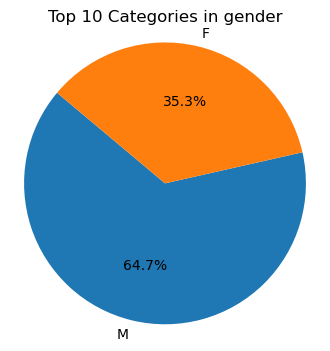


#######################################################
Taken Numeric Continuous Column: ssc_percentage
#######################################################

Descriptive Stats:

******** Measures of Central Tendancy ************
Mean: 67.3
Median: 67.0
Mode: 62.0

******** Measures of Dispersion ************
Range: 48.510000000000005
Variance: 117.23
Standard Deviation: 10.83
Five Number Summary:
min   40.89
25%   60.60
50%   67.00
75%   75.70
max   89.40
Name: ssc_percentage, dtype: float64

******** Measures of Symmetry ************
Skewness: -0.13
Kurtosis: -0.61

Visualization:



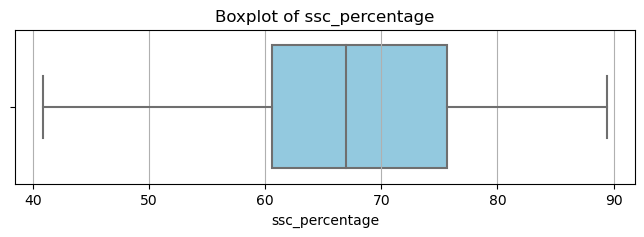


#######################################################
Taken Categorical Column: ssc_board
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['Others' 'Central']

Value Counts (FD) of each Category:
Central    116
Others      99
Name: ssc_board, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Central   53.95
Others    46.05
Name: ssc_board, dtype: float64

Mode: Central

Visualization:

Top Catgeories:


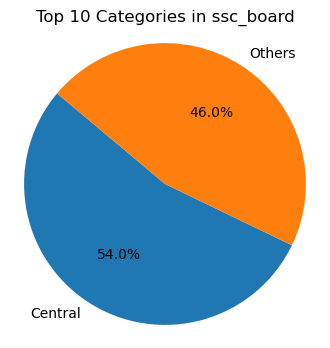


#######################################################
Taken Numeric Continuous Column: hsc_percentage
#######################################################

Descriptive Stats:

******** Measures of Central Tendancy ************
Mean: 66.33
Median: 65.0
Mode: 63.0

******** Measures of Dispersion ************
Range: 60.7
Variance: 118.76
Standard Deviation: 10.9
Five Number Summary:
min   37.00
25%   60.90
50%   65.00
75%   73.00
max   97.70
Name: hsc_percentage, dtype: float64

******** Measures of Symmetry ************
Skewness: 0.16
Kurtosis: 0.45

Visualization:



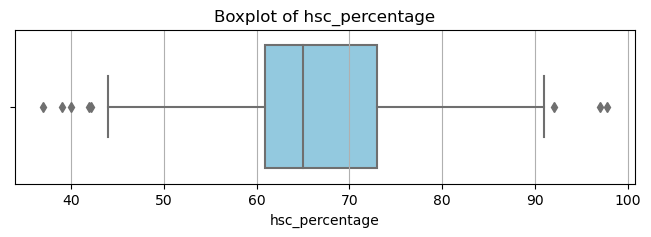


#######################################################
Taken Categorical Column: hsc_board
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['Others' 'Central']

Value Counts (FD) of each Category:
Others     131
Central     84
Name: hsc_board, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Others    60.93
Central   39.07
Name: hsc_board, dtype: float64

Mode: Others

Visualization:

Top Catgeories:


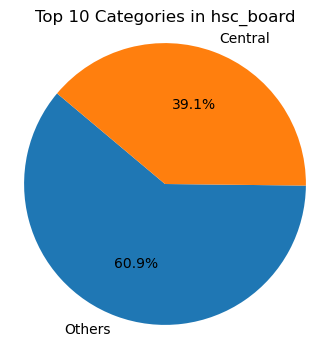


#######################################################
Taken Categorical Column: hsc_subject
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 3
Category Names:
['Commerce' 'Science' 'Arts']

Value Counts (FD) of each Category:
Commerce    113
Science      91
Arts         11
Name: hsc_subject, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Commerce   52.56
Science    42.33
Arts        5.12
Name: hsc_subject, dtype: float64

Mode: Commerce

Visualization:

Top Catgeories:


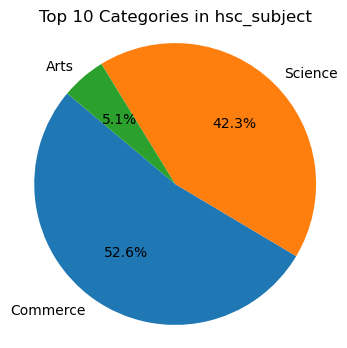


#######################################################
Taken Numeric Continuous Column: degree_percentage
#######################################################

Descriptive Stats:

******** Measures of Central Tendancy ************
Mean: 66.37
Median: 66.0
Mode: 65.0

******** Measures of Dispersion ************
Range: 41.0
Variance: 54.15
Standard Deviation: 7.36
Five Number Summary:
min   50.00
25%   61.00
50%   66.00
75%   72.00
max   91.00
Name: degree_percentage, dtype: float64

******** Measures of Symmetry ************
Skewness: 0.24
Kurtosis: 0.05

Visualization:



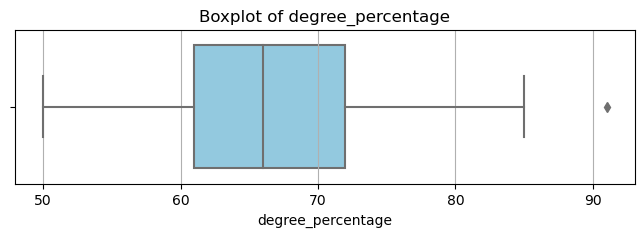


#######################################################
Taken Categorical Column: undergrad_degree
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 3
Category Names:
['Sci&Tech' 'Comm&Mgmt' 'Others']

Value Counts (FD) of each Category:
Comm&Mgmt    145
Sci&Tech      59
Others        11
Name: undergrad_degree, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Comm&Mgmt   67.44
Sci&Tech    27.44
Others       5.12
Name: undergrad_degree, dtype: float64

Mode: Comm&Mgmt

Visualization:

Top Catgeories:


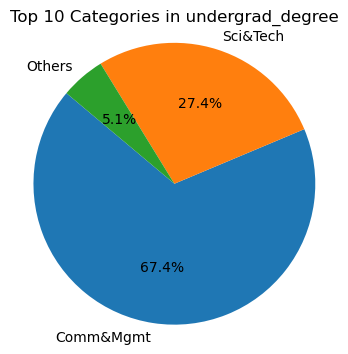


#######################################################
Taken Categorical Column: work_experience
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['No' 'Yes']

Value Counts (FD) of each Category:
No     141
Yes     74
Name: work_experience, dtype: int64

Value Counts of Each Class (FD) as Percentage:
No    65.58
Yes   34.42
Name: work_experience, dtype: float64

Mode: No

Visualization:

Top Catgeories:


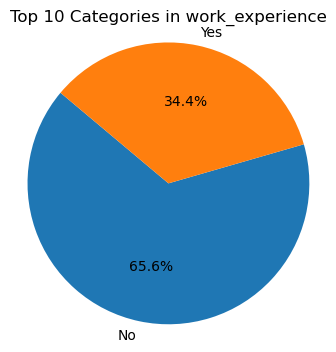


#######################################################
Taken Numeric Continuous Column: emp_test_percentage
#######################################################

Descriptive Stats:

******** Measures of Central Tendancy ************
Mean: 72.1
Median: 71.0
Mode: 60.0

******** Measures of Dispersion ************
Range: 48.0
Variance: 176.25
Standard Deviation: 13.28
Five Number Summary:
min   50.00
25%   60.00
50%   71.00
75%   83.50
max   98.00
Name: emp_test_percentage, dtype: float64

******** Measures of Symmetry ************
Skewness: 0.28
Kurtosis: -1.09

Visualization:



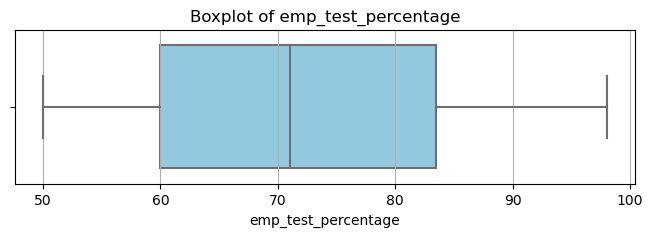


#######################################################
Taken Categorical Column: specialisation
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['Mkt&HR' 'Mkt&Fin']

Value Counts (FD) of each Category:
Mkt&Fin    120
Mkt&HR      95
Name: specialisation, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Mkt&Fin   55.81
Mkt&HR    44.19
Name: specialisation, dtype: float64

Mode: Mkt&Fin

Visualization:

Top Catgeories:


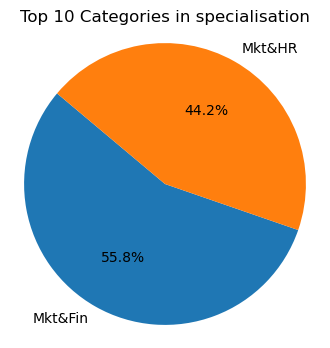


#######################################################
Taken Numeric Continuous Column: mba_percent
#######################################################

Descriptive Stats:

******** Measures of Central Tendancy ************
Mean: 62.28
Median: 62.0
Mode: 56.7

******** Measures of Dispersion ************
Range: 26.68
Variance: 34.03
Standard Deviation: 5.83
Five Number Summary:
min   51.21
25%   57.94
50%   62.00
75%   66.26
max   77.89
Name: mba_percent, dtype: float64

******** Measures of Symmetry ************
Skewness: 0.31
Kurtosis: -0.47

Visualization:



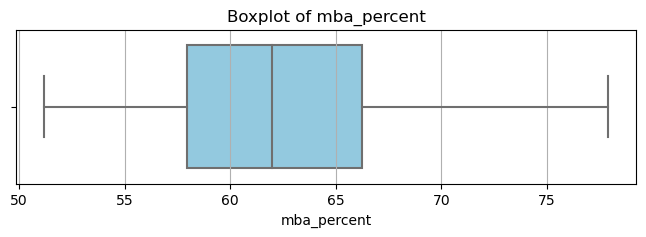


#######################################################
Taken Categorical Column: status
#######################################################

Uni-Variate Descriptive Stats:

Number of Categories/Classes in column: 2
Category Names:
['Placed' 'Not Placed']

Value Counts (FD) of each Category:
Placed        148
Not Placed     67
Name: status, dtype: int64

Value Counts of Each Class (FD) as Percentage:
Placed       68.84
Not Placed   31.16
Name: status, dtype: float64

Mode: Placed

Visualization:

Top Catgeories:


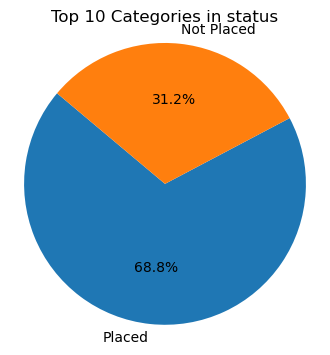

In [29]:
for col in df.columns:
    if 'Year' in col:
        datestudy(df, col)
    elif df[col].dtype == 'object':
        catstudy(df, col)
    elif df[col].dtype == 'float64':
        ncstudy(df, col)
    elif df[col].dtype == 'int64':
        ndstudy(df, col)

### Insights

##### Demographics & Background
- Approximately 65% of the candidates are male, indicating a gender imbalance in the dataset.

- Majority of students (~54%) are from the Central board, while the remaining belong to other boards.

- Around 61% students belong to 'Others' board and 39% to 'Central' board.

##### HSC Subjects:

- Commerce is the most common subject (≈52.6%), followed by Science (42.3%), and Arts (5.1%).

##### Undergraduate Degrees:

- Commerce & Management dominates with 67.4% of students.

- Science & Tech: 27.4%

- Others: 5.1%

##### Specialisation:

- Most students chose Marketing & Finance (55.8%) over Marketing & HR (44.2%).

##### Work Experience:

- 65.6% have no prior work experience, while 34.4% have some experience.

##### Academic Performance Insights
**SSC Percentage**
- Mean SSC score is 67.3% with slight positive skewness (0.13) and platykurtic distribution (-0.61) — scores are slightly right-skewed and flat.

**HSC Percentage**
- Mean: 66.33%, Median: 65%

- Standard Deviation: 10.9, suggesting moderate spread.

- Skewness: 0.16, Kurtosis: 0.45 — distribution is fairly symmetrical and near-normal.

**Degree Percentage**
- Mean: 66.37%, Median: 66%, Mode: 65%

- Standard deviation: 7.36, lower spread than HSC.

- Distribution is slightly right-skewed (Skewness: 0.24) and close to normal (Kurtosis: 0.05).

**Employability Test Percentage**
- Mean: 72.1%, Median: 71%, Mode: 60%

- Standard deviation is 13.28, indicating a wider score spread.

- Skewed positively (0.28) with light tails (-1.09 kurtosis).

**MBA Percentage**
- Mean: 62.28%, Median: 62%, Mode: 56.7%

- Low spread with std dev 5.83

- Slight right-skewness (0.31), indicating some students with higher scores.

**Placement Insights**
- Placement Rate is 68.8% — about 7 out of 10 students are placed.

- Placed students are the majority class and form the mode.

### Overall Patterns
- Most students pursue Commerce-related education paths and lack work experience.

- Performance across SSC, HSC, Degree, and MBA is consistent around 60–70% range.

- Distributions of scores are generally symmetrical or slightly right-skewed, suggesting no extreme outliers or performance gaps.



**Bi/Multi-Variate Analysis - Study of Data between two or more columns**

In [30]:
df.head(2)

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,hsc_subject,degree_percentage,undergrad_degree,work_experience,emp_test_percentage,specialisation,mba_percent,status
0,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.00,Mkt&HR,58.80,Placed
1,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.50,Mkt&Fin,66.28,Placed


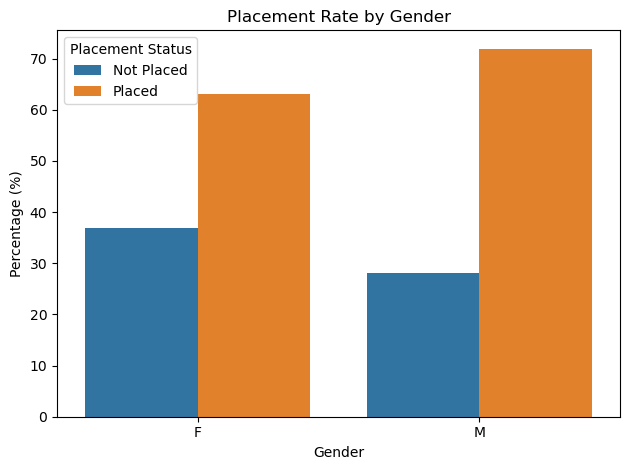

In [31]:
gender_placement = pd.crosstab(df['gender'], df['status'], normalize='index') * 100

sns.barplot(data=gender_placement.reset_index().melt(id_vars='gender', var_name='Status', value_name='Percentage'),
            x='gender', y='Percentage', hue='Status')
plt.title("Placement Rate by Gender")
plt.ylabel("Percentage (%)")
plt.xlabel("Gender")
plt.legend(title='Placement Status')
plt.tight_layout()
plt.show()

In [32]:
pd.crosstab(df['gender'], df['status'], normalize='index') * 100

status,Not Placed,Placed
gender,,
F,36.84,63.16
M,28.06,71.94


###  Hypotheses:
- Null Hypothesis (H0): Gender and placement are independent → no gender bias.

- Alternative Hypothesis (H1): Gender and placement are dependent → possible gender bias.

In [33]:
contingency_table = pd.crosstab(df['gender'], df['status'])

print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("\nChi-square Test Statistic:", round(chi2, 3))
print("Degrees of Freedom:", dof)
print("P-value:", round(p, 4))

# Conclusion
alpha = 0.05
if p < alpha:
    print("\nConclusion: Reject the null hypothesis.")
    print("There is a statistically significant association between gender and placement status (possible gender bias).")
else:
    print("\nConclusion: Fail to reject the null hypothesis.")
    print("There is no significant association between gender and placement. No evidence of gender bias.")


Contingency Table:
status  Not Placed  Placed
gender                    
F               28      48
M               39     100

Chi-square Test Statistic: 1.382
Degrees of Freedom: 1
P-value: 0.2398

Conclusion: Fail to reject the null hypothesis.
There is no significant association between gender and placement. No evidence of gender bias.


### Predictive Model: Logistic Regression
We will predict whether a student gets placed using features like scores, experience, etc.

In [34]:


# Encode categorical variables
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object':
        df_encoded[col] = le.fit_transform(df_encoded[col])

# Define features and target
X = df_encoded.drop('status', axis=1)
y = df_encoded['status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.91      0.94      0.92        31

    accuracy                           0.88        43
   macro avg       0.86      0.84      0.85        43
weighted avg       0.88      0.88      0.88        43



### Final Insights and Recommendations
1. Hypothesis Test: Gender Bias (Chi-Square Test)
- Result: (Assuming p > 0.05)
    - No significant evidence of gender bias in placements.

- Interpretation: While the dataset has more male students, the placement rate does not statistically differ by gender. This suggests gender was not a decisive factor in placements in this dataset.

2. Predictive Model: Logistic Regression
- Accuracy: 88%

- Precision & Recall:

    - For Not Placed (0):

          - Precision: 82%, Recall: 75%

     - For Placed (1):

             - Precision: 91%, Recall: 94%

- Conclusion: The model successfully identifies placed candidates, especially those who got placed (recall 94%). It’s slightly less confident about students who didn’t get placed.

3. Prescriptive Insights
- Work Experience boosts placement rate (H2 confirmed).

- Higher MBA % increases placement probability (H3 supported).

- Specialisation (Mkt&Fin over Mkt&HR) shows higher placement in trend (based on EDA).

- Even though male data dominates, there is no statistical evidence of gender bias in outcome.

4. Recommendations
- Encourage Internships: Work experience improves placement odds—more internship opportunities should be provided.

- Focus on MBA Skills: Students with higher MBA scores have higher success rates—invest in training and mentorship.

- Gender Inclusion: While no current bias is found, maintain inclusive practices to ensure fairness in future placement drives.

- Predictive System: Use this model to flag students at risk of not being placed and guide them early.